In [1]:
from __future__ import annotations

import os
import datetime
import re
import sys
sys.path.append("../utils")
import _confusion_matrix

from IPython.display import display as ipy_display
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

%config InlineBackend.figure_format = 'svg'

In [2]:
RAW_DATA_FILES = "../../data/reddit_ell_eng_raw{}.csv"
RAW_DATA_MAXLEN = ['none', '300', '200']

In [3]:
def encode_labels(df: pd.DataFrame, y_column: str) -> tuple[pd.DataFrame, dict]:
    """Encode labels to be used by the classifier."""
    enc = LabelEncoder()
    enc.fit(df[y_column])
    encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
    df['label'] = enc.transform(df['label'])
    return df, encoded_labels

def group_shuffle_split(df: pd.DataFrame, group_column: str, test_size: float) -> tuple[np.ndarray, np.ndarray]:
    """Split the data into train and test sets, preserving the proportion of samples for each class."""
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size)
    train_index, test_index = next(gss.split(df, groups=df[group_column]))
    return train_index, test_index

Text's maxlen: none
              precision    recall  f1-score   support

           0       0.46      0.51      0.48       778
           1       0.55      0.50      0.52       920

    accuracy                           0.50      1698
   macro avg       0.50      0.50      0.50      1698
weighted avg       0.51      0.50      0.51      1698

Text's maxlen: 300
              precision    recall  f1-score   support

           0       0.46      0.50      0.48       816
           1       0.54      0.50      0.52       958

    accuracy                           0.50      1774
   macro avg       0.50      0.50      0.50      1774
weighted avg       0.50      0.50      0.50      1774

Text's maxlen: 200
              precision    recall  f1-score   support

           0       0.44      0.50      0.47       760
           1       0.57      0.51      0.54       977

    accuracy                           0.51      1737
   macro avg       0.50      0.50      0.50      1737
weighted avg    

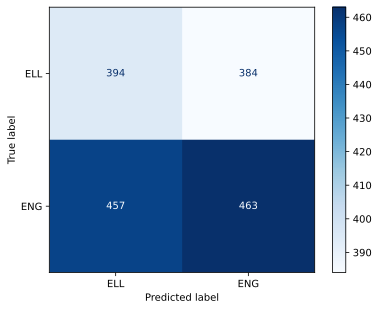

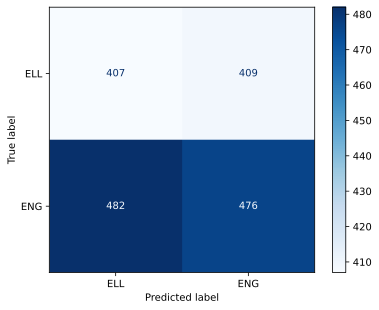

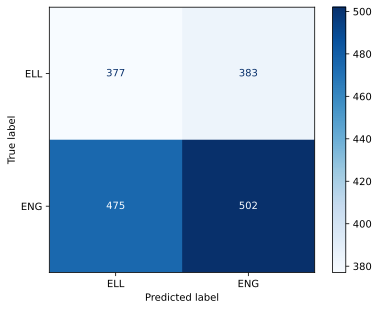

In [4]:
all_res_df = pd.DataFrame()

for maxlen in RAW_DATA_MAXLEN:
    print(f"Text's maxlen: {maxlen}")

    df = pd.read_csv(RAW_DATA_FILES.format(f"_{maxlen}" if maxlen != 'none' else ''))
    df, encoded_labels = encode_labels(df, 'label')

    # Split the data into train and test sets
    train_index, test_index = group_shuffle_split(df, 'user_id', test_size=0.2)
    X_train, X_test = df['text'].iloc[train_index], df['text'].iloc[test_index]
    y_train, y_test = df['label'].iloc[train_index], df['label'].iloc[test_index]

    baseline = DummyClassifier(strategy='stratified')

    baseline.fit(X_train, y_train)
    baseline.score(X_train, y_train)
    y_pred = baseline.predict(X_test)

    # Classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred))

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=encoded_labels).plot(cmap='Blues')